In [1]:
import os
# import re
import glob
import random
import yaml
import shutil
from shutil import copyfile
import json

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
import seaborn as sns
from scipy.spatial.distance import jensenshannon
import time

# Image processing and display
import IPython.display as display
from PIL import Image
import cv2

# YOLO model from Ultralytics
import ultralytics
from ultralytics import YOLO

In [2]:
ultralytics.checks()


Ultralytics 8.3.144  Python-3.9.21 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3080 Laptop GPU, 8192MiB)
Setup complete  (16 CPUs, 15.4 GB RAM, 486.3/930.4 GB disk)


In [3]:
! wandb disabled


'wandb' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
class Config:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 42

    TARGET_RATIOS = {'train': 0.80, 'valid': 0.15, 'test': 0.05}

    # classes
    # Class map from dataset description
    PPE_CLASSES = {
        0: "Hardhat",
        1: "Mask",
        2: "NO-Hardhat",
        3: "NO-Mask",
        4: "NO-Safety Vest",
        5: "Person",
        6: "Safety Cone",
        7: "Safety Vest",
        8: "Machinery",
        9: "Vehicle"
    }
    # NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 30 # 100
    BATCH_SIZE = 16
    IMGSZ = 640  # Redimensiona para 640x640
    RECT = False # or True -> but makes shuffle = false due imcompatibility 
    VERBOSE = False # Suppress detailed logs
    SHOW_LABELS = False # Hide labels in console output
    SHOW_CONF = False # Hide confidence scores in output
    SHOW_BOXES = False # Hide bounding boxes in terminal output
    BASE_MODEL = 'yolo11n.pt' # 'yolo11n.pt' 'yolo11s.pt' 'yolo11l.pt' 'yolo11x.pt'
    DEVICE = "cuda"

    # paths
    CSS_DATA_PATH = 'construction-site-safety-image-dataset-roboflow/css-data'
    OUTPUT_PATH = './'
    WORKING_PATH = "final_dataset"
    FOLDERS = ["train", "valid", "test"]

    # Define the path to save the training results
    TRAIN_RESULTS = f"{WORKING_PATH}/train_results.csv"
    MODEL_PATH = f'{WORKING_PATH}/runs/detect/train/weights/best.pt'
    OUTPUT_MODEL_PATH = f'{WORKING_PATH}/best.pt'
    METADATA_PATH = f'{WORKING_PATH}/metadata.json'

In [7]:
for folder in Config.FOLDERS:
    image_path = os.path.join(Config.CSS_DATA_PATH, folder, "images")
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, "labels")

    images = set(f.rsplit(".", 1)[0] for f in os.listdir(image_path) if f.endswith((".jpg", ".png")))
    labels = set(f.rsplit(".", 1)[0] for f in os.listdir(label_path) if f.endswith(".txt"))

    missing_labels = images - labels  # Imagens sem labels
    missing_images = labels - images  # Labels sem imagens

    print(f"📂 {folder.upper()} SET:")
    print(f" - Total Images: {len(images)}")
    print(f" - Total Labels: {len(labels)}")
    print(f" - Sample Image Names: {list(images)[:2]}")
    print(f" - Sample Label Names: {list(labels)[:2]}")
    print(f" - Missing Labels: {len(missing_labels)} → {list(missing_labels)[:2]}")
    print(f" - Missing Images: {len(missing_images)} → {list(missing_images)[:2]}")
    print("-" * 40)

📂 TRAIN SET:
 - Total Images: 2605
 - Total Labels: 2605
 - Sample Image Names: ['IMG_0871_mp4-5_jpg.rf.d8a9e349bf878db698469433d9778d75', 'youtube-622_jpg.rf.5cedb2fa20d0d25a6d0d775bdd1e09e2']
 - Sample Label Names: ['IMG_0871_mp4-5_jpg.rf.d8a9e349bf878db698469433d9778d75', 'youtube-622_jpg.rf.5cedb2fa20d0d25a6d0d775bdd1e09e2']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
----------------------------------------
📂 VALID SET:
 - Total Images: 114
 - Total Labels: 114
 - Sample Image Names: ['class1_267_jpg.rf.ab7a08d97aba5b0748e976df6e65700a', 'construction-277-_jpg.rf.bf73a4edc7a1f7d412bc3267cbafcda7']
 - Sample Label Names: ['class1_267_jpg.rf.ab7a08d97aba5b0748e976df6e65700a', 'construction-277-_jpg.rf.bf73a4edc7a1f7d412bc3267cbafcda7']
 - Missing Labels: 0 → []
 - Missing Images: 0 → []
----------------------------------------
📂 TEST SET:
 - Total Images: 82
 - Total Labels: 82
 - Sample Image Names: ['construction-675-_jpg.rf.bb4a05441be707256175e04929da3478', 'construction

In [8]:
# Number of label files to display per folder
num_samples = 3

# Read label files from each folder
for folder in Config.FOLDERS:
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    print(f"📂 {folder.upper()} LABELS CONTENT:")

    # Display content of up to num_samples label files
    for label_file in label_files[:num_samples]:
        file_path = os.path.join(label_path, label_file)

        with open(file_path, "r") as f:
            content = f.readlines()

        print(f"📄 {label_file}:")
        for line in content:
            print(f"  {line.strip()}")  # Display without extra line breaks
        print("-" * 50)

📂 TRAIN LABELS CONTENT:
📄 -1670-_png_jpg.rf.0463edb430019e01ec79eed27a6349d6.txt:
  0 0.0775416543763631 0.39375 0.09097043364502548 0.059375
  0 0.01640625 0.41328125 0.0328125 0.1203125
  3 0.04682291950167361 0.43671875 0.03935339149054773 0.05
  3 0.09124054001317838 0.45625 0.05019998789975162 0.034375
  5 0.16328125 0.4203125 0.3265625 0.178125
  5 0.17578125 0.43046875 0.2859375 0.1578125
  1 0.2578125 0.87109375 0.34375 0.2578125
  2 0.25390625 0.5953125 0.3515625 0.171875
  5 0.21484375 0.7546875 0.4296875 0.490625
  1 0.7734375 0.8890625 0.4375 0.221875
  2 0.78046875 0.6453125 0.4390625 0.175
  5 0.71484375 0.76953125 0.5703125 0.4609375
--------------------------------------------------
📄 -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38f929.txt:
  5 0.1046875 0.38984375 0.209375 0.1578125
  5 0.1 0.40078125 0.2 0.1359375
  3 0.7658004593809523 0.00546875 0.007921588001272717 0.009375
  4 0.7573885227164068 0.02109375 0.034865896005727134 0.0421875
  4 0.8380572673854066 0.038

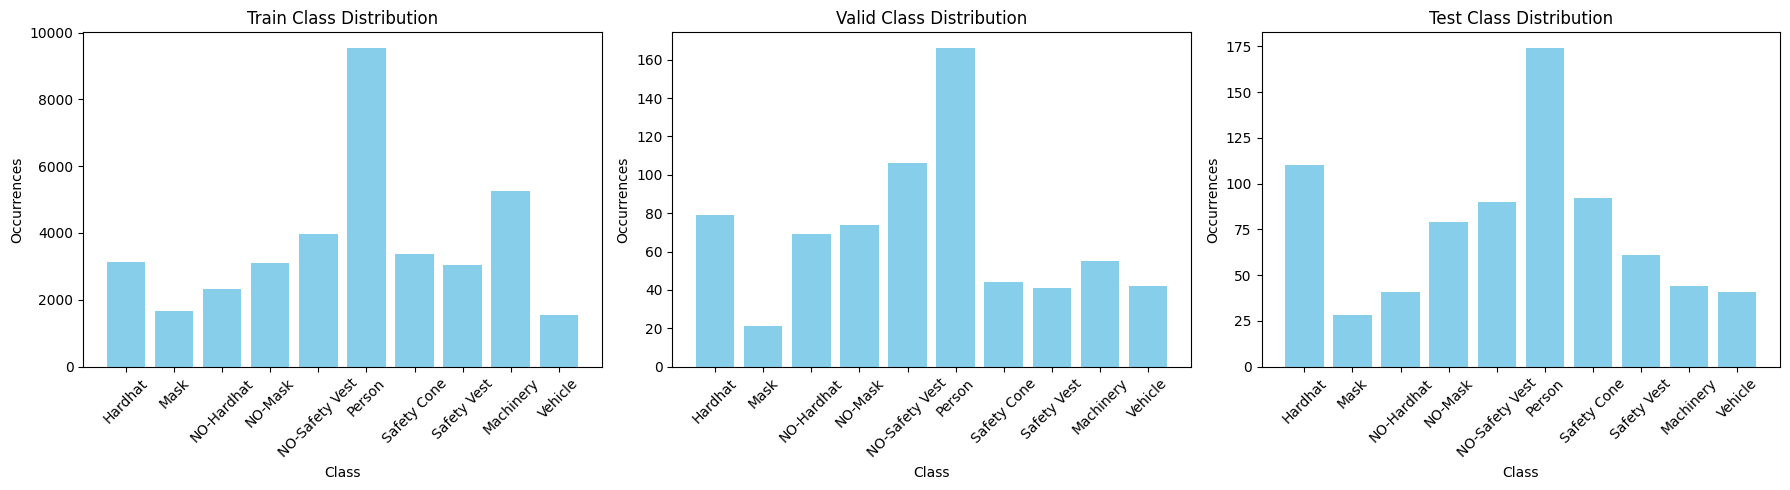

In [9]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in Config.PPE_CLASSES.keys()} for folder in Config.FOLDERS}

# Count occurrences of each class in train and validation datasets
for folder in Config.FOLDERS:
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Plot class distribution with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Adjust for three plots

for i, folder in enumerate(Config.FOLDERS):
    counts = class_counts[folder]
    classes = [Config.PPE_CLASSES[k] for k in counts.keys()]
    values = list(counts.values())

    axes[i].bar(classes, values, color="skyblue")
    axes[i].set_title(f"{folder.capitalize()} Class Distribution")
    axes[i].set_xlabel("Class")
    axes[i].set_ylabel("Occurrences")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

C:\Users\mmsvl\AppData\Local\Temp\ipykernel_26168\2492732392.py:43: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette=palette)


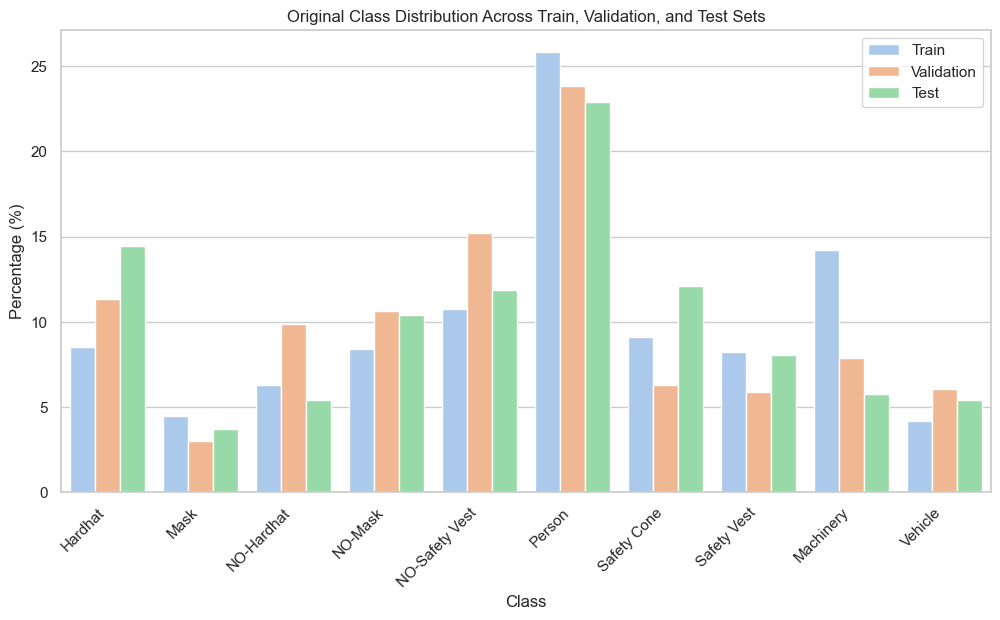

In [10]:
# Initialize class counters
class_counts = {folder: {cls: 0 for cls in Config.PPE_CLASSES.keys()} for folder in Config.FOLDERS}

# Count occurrences of each class in train, validation, and test datasets
for folder in Config.FOLDERS:
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, "labels")
    label_files = [f for f in os.listdir(label_path) if f.endswith(".txt")]

    for label_file in label_files:
        file_path = os.path.join(label_path, label_file)
        
        with open(file_path, "r") as f:
            lines = f.readlines()
        
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID from each annotation
            class_counts[folder][class_id] += 1  # Increment class count

# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in Config.FOLDERS
}

# Convert to DataFrame for plotting
df_plot = pd.DataFrame({
    "Class": list(Config.PPE_CLASSES.values()) * 3,  # Repeat classes for each dataset
    "Percentage": list(class_percentages["train"].values()) + 
                  list(class_percentages["valid"].values()) + 
                  list(class_percentages["test"].values()),
    "Dataset": ["Train"] * len(class_percentages["train"]) + 
               ["Validation"] * len(class_percentages["valid"]) + 
               ["Test"] * len(class_percentages["test"])
})

# Set theme and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("pastel")

# Plot using sns.barplot()
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette=palette)

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Original Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")
plt.legend()

# Show the plot
plt.show()

In [11]:
# Convert to percentages
class_percentages = {
    folder: {cls: (count / sum(class_counts[folder].values())) * 100 if sum(class_counts[folder].values()) > 0 else 0
             for cls, count in class_counts[folder].items()}
    for folder in Config.FOLDERS
}

# Convert percentages to arrays
train_dist = np.array(list(class_percentages["train"].values()))
valid_dist = np.array(list(class_percentages["valid"].values()))
test_dist = np.array(list(class_percentages["test"].values()))

# Compute standard deviation (spread of the distribution)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) for each dataset
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon Divergence
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")

📊 Standard Deviation of Class Distribution:
   Train: 5.97, Valid: 5.66, Test: 5.46

📊 Coefficient of Variation (Lower is better):
   Train: 59.66%, Valid: 56.55%, Test: 54.61%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.1193, Train vs Test: 0.1264


In [12]:
# Initialize an empty dictionary to store class counts
classes_dict = {}

# Iterate over dataset splits
for subset_folder in Config.FOLDERS:
    label_folder = glob.glob(os.path.join(Config.CSS_DATA_PATH, subset_folder, 'labels', '*.txt'))
    cl = []
    
    # Read annotation files
    for anno_file in label_folder:
        with open(anno_file, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
            cl.extend([line.split()[0] for line in lines])  # Extract class ID correctly
    
    # Count occurrences of each class
    cl_count = {str(c): cl.count(str(c)) for c in range(10)}  # Ensure all classes (0-9) are included
    classes_dict[subset_folder] = cl_count

# Convert dictionary to DataFrame
df_class_distribution = pd.DataFrame(classes_dict).fillna(0).astype(int)

# Rename index to represent class names
df_class_distribution.index.name = "Class ID"

# Print the DataFrame
print(df_class_distribution)

          train  valid  test
Class ID                    
0          3145     79   110
1          1651     21    28
2          2317     69    41
3          3097     74    79
4          3962    106    90
5          9532    166   174
6          3366     44    92
7          3033     41    61
8          5247     55    44
9          1545     42    41


In [13]:
# Classes from PPE dataset (0-9)
classes = list(Config.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in Config.FOLDERS:
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Read the label file and count occurrences of each class
        class_counts = {cls: 0 for cls in Config.PPE_CLASSES.keys()}  # Initialize all classes with 0
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_counts[class_id] += 1  # Count occurrences

        # Create a row with the filename, origin, and class occurrences
        row = {'filename': img_name, 'origin': folder}
        row.update(class_counts)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...  train  2  2  2  2  0  4   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...  train  2  0  0  2  4  9   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...  train  1  0  1  0  2  2   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...  train  3  0  0  3  3  7   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...  train  2  0  1  3  2  6   

   6  7  8  9  
0  0  0  0  0  
1  0  2  0  0  
2  0  0  2  0  
3  0  0  6  0  
4  0  1  5  0  


In [14]:
df_total.describe()


,0,1,2,3,4,5,6,7,8,9
count,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000,2801.000000
mean,1.190289,0.606926,0.866476,1.160300,1.484470,3.524456,1.250268,1.119243,1.908604,0.581221
std,2.282822,1.019143,1.256421,1.824342,1.627177,2.903359,4.419258,2.203258,1.744236,1.426506
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,0.000000,1.000000,3.000000,1.000000
max,22.000000,10.000000,13.000000,21.000000,16.000000,24.000000,46.000000,20.000000,13.000000,15.000000


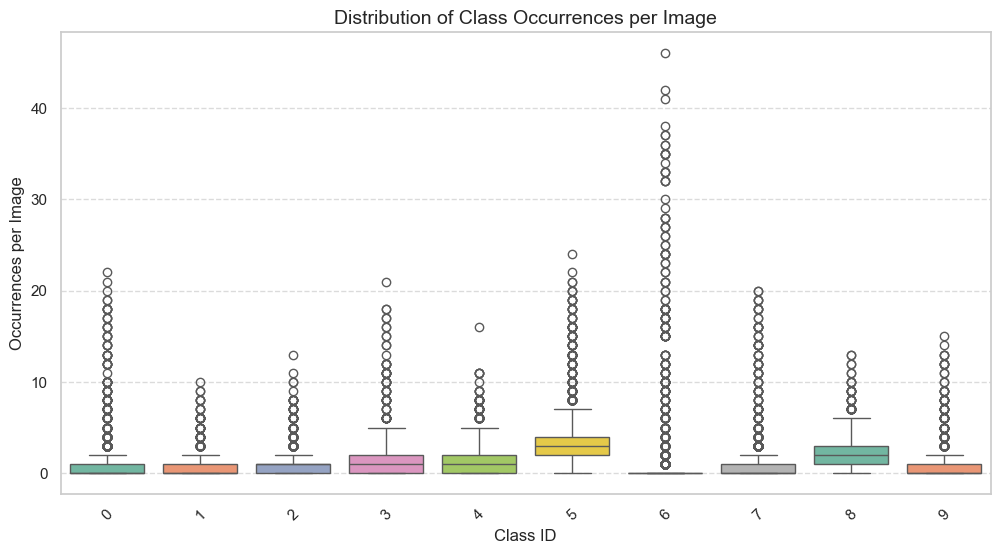

In [15]:
# Set figure size
plt.figure(figsize=(12, 6))

# Create boxplot
sns.boxplot(data=df_total.iloc[:, 2:], palette="Set2")

# Set title and labels
plt.title("Distribution of Class Occurrences per Image", fontsize=14)
plt.xlabel("Class ID", fontsize=12)
plt.ylabel("Occurrences per Image", fontsize=12)

# Show plot
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [16]:
# Classes from PPE dataset (0-9)
classes = list(Config.PPE_CLASSES.keys())

# Initialize an empty list to store image metadata
data = []

# Iterate over train, valid, and test folders
for folder in Config.FOLDERS:
    label_path = os.path.join(Config.CSS_DATA_PATH, folder, 'labels')
    label_files = glob.glob(os.path.join(label_path, '*.txt'))

    for label_file in label_files:
        # Extract image filename (without extension)
        img_name = os.path.basename(label_file).replace('.txt', '')

        # Initialize class presence as 0 for all classes
        class_presence = {cls: 0 for cls in Config.PPE_CLASSES.keys()}

        # Read the label file and mark presence of each class
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract class ID
                class_presence[class_id] = 1  # Mark presence (1)

        # Create a row with the filename, origin, and class presence
        row = {'filename': img_name, 'origin': folder}
        row.update(class_presence)

        # Append to the dataset
        data.append(row)

# Convert list to DataFrame
df_total = pd.DataFrame(data)

# Print dataset summary
print(f"📊 Total images: {len(df_total)}")
print(df_total.head())

📊 Total images: 2801
                                            filename origin  0  1  2  3  4  5  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...  train  1  1  1  1  0  1   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...  train  1  0  0  1  1  1   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...  train  1  0  1  0  1  1   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...  train  1  0  0  1  1  1   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...  train  1  0  1  1  1  1   

   6  7  8  9  
0  0  0  0  0  
1  0  1  0  0  
2  0  0  1  0  
3  0  0  1  0  
4  0  1  1  0  


In [17]:
# Create empty lists to store rows for each dataset
train_data = []
valid_data = []
test_data = []

# Define target proportions
target_ratios = Config.TARGET_RATIOS  # {'train': 0.80, 'valid': 0.15, 'test': 0.05}
total_images = len(df_total)
target_sizes = {subset: int(total_images * target_ratios[subset]) for subset in Config.FOLDERS}

# Initialize counters for class distribution in each set
class_distribution = {
    'train': {cls: 0 for cls in Config.PPE_CLASSES.keys()},
    'valid': {cls: 0 for cls in Config.PPE_CLASSES.keys()},
    'test': {cls: 0 for cls in Config.PPE_CLASSES.keys()}
}

# Shuffle df_total to randomize image order
df_total = df_total.sample(frac=1, random_state=Config.SEED).reset_index(drop=True)

# Step 1: Fill TRAIN dataset first
for _, row in df_total.iterrows():
    if len(train_data) < target_sizes['train']:
        train_data.append(row)
        for cls in Config.PPE_CLASSES.keys():
            class_distribution['train'][cls] += row[cls]

# Remaining images to be distributed between valid and test
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data])]

# Step 2: Distribute remaining images to VALID and TEST
for _, row in remaining_images.iterrows():
    if len(valid_data) < target_sizes['valid']:
        valid_data.append(row)
        for cls in Config.PPE_CLASSES.keys():
            class_distribution['valid'][cls] += row[cls]
    elif len(test_data) < target_sizes['test']:
        test_data.append(row)
        for cls in Config.PPE_CLASSES.keys():
            class_distribution['test'][cls] += row[cls]

# Step 3: If any images are left, assign them to train
remaining_images = df_total[~df_total['filename'].isin([x['filename'] for x in train_data + valid_data + test_data])]

for _, row in remaining_images.iterrows():
    train_data.append(row)
    for cls in Config.PPE_CLASSES.keys():
        class_distribution['train'][cls] += row[cls]

# Convert lists to DataFrames
df_train = pd.DataFrame(train_data)
df_valid = pd.DataFrame(valid_data)
df_test = pd.DataFrame(test_data)

In [18]:
# Total number of processed images
total_assigned = len(df_train) + len(df_valid) + len(df_test)

# Actual proportions
train_ratio = len(df_train) / total_assigned
valid_ratio = len(df_valid) / total_assigned
test_ratio = len(df_test) / total_assigned

# Display proportions
print(f"✅ Total assigned images: {total_assigned} (Expected: {len(df_total)})")
print(f"📊 Train: {len(df_train)} images ({train_ratio:.2%})")
print(f"📊 Validation: {len(df_valid)} images ({valid_ratio:.2%})")
print(f"📊 Test: {len(df_test)} images ({test_ratio:.2%})")

# Check if any images are missing
missing_images = set(df_total['filename']) - set(df_train['filename']) - set(df_valid['filename']) - set(df_test['filename'])

if missing_images:
    print(f"⚠️ {len(missing_images)} image(s) were not assigned!")
    print("🔍 Displaying details of missing images in df_total:")

    # Display details of missing images
    missing_df = df_total[df_total['filename'].isin(missing_images)]
    print(missing_df)  # Displays the DataFrame in the notebook
else:
    print("✅ No images were lost!")

✅ Total assigned images: 2801 (Expected: 2801)
📊 Train: 2241 images (80.01%)
📊 Validation: 420 images (14.99%)
📊 Test: 140 images (5.00%)
✅ No images were lost!


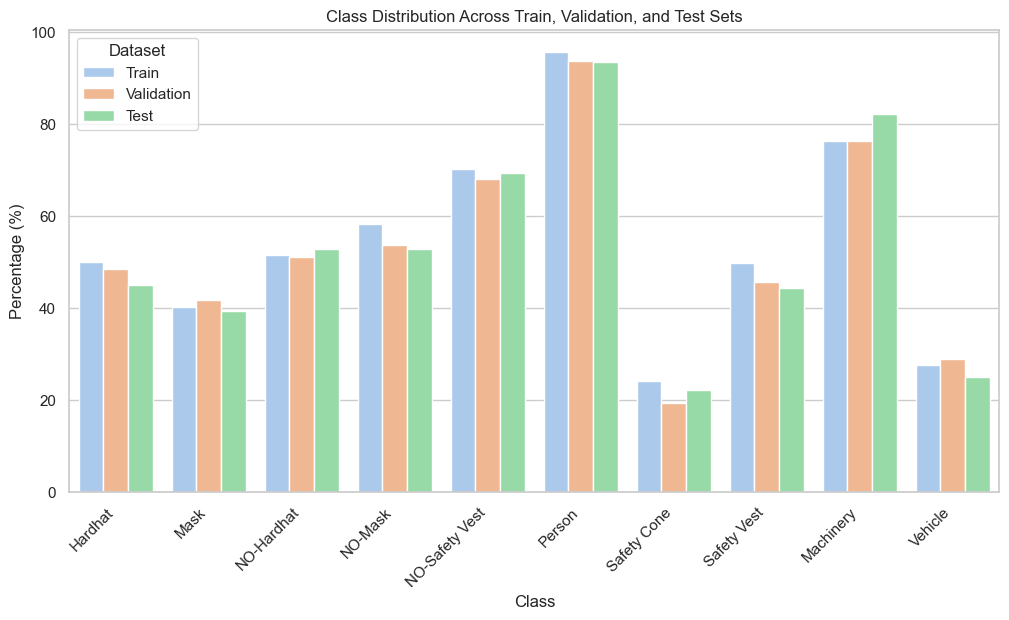

In [19]:
# Set theme and pastel color palette
sns.set_theme(style="whitegrid")  # Define o tema

# Calculate class distributions in percentage
def compute_class_percentage(df):
    total = len(df)
    return {cls: (df[cls].sum() / total) * 100 for cls in Config.PPE_CLASSES.keys()}

train_percentages = compute_class_percentage(df_train)
valid_percentages = compute_class_percentage(df_valid)
test_percentages = compute_class_percentage(df_test)

# Convert to a DataFrame for Seaborn
df_plot = pd.DataFrame({
    "Class": list(Config.PPE_CLASSES.values()) * 3,  # Repete as classes 3 vezes (para cada conjunto)
    "Percentage": list(train_percentages.values()) + list(valid_percentages.values()) + list(test_percentages.values()),
    "Dataset": ["Train"] * len(train_percentages) + ["Validation"] * len(valid_percentages) + ["Test"] * len(test_percentages)
})

# Create the plot using sns.barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Percentage", hue="Dataset", data=df_plot, palette="pastel")

# Labels and formatting
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Class Distribution Across Train, Validation, and Test Sets")
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


In [20]:
# Convert percentages to arrays
train_dist = np.array(list(train_percentages.values()))
valid_dist = np.array(list(valid_percentages.values()))
test_dist = np.array(list(test_percentages.values()))

# Compute standard deviation (how spread out the class distributions are)
train_std = np.std(train_dist)
valid_std = np.std(valid_dist)
test_std = np.std(test_dist)

# Compute Coefficient of Variation (CV) to assess balance
train_cv = (train_std / np.mean(train_dist)) * 100
valid_cv = (valid_std / np.mean(valid_dist)) * 100
test_cv = (test_std / np.mean(test_dist)) * 100

# Compute Jensen-Shannon divergence between Train-Valid and Train-Test
jsd_train_valid = jensenshannon(train_dist, valid_dist)
jsd_train_test = jensenshannon(train_dist, test_dist)

# Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Train: {train_std:.2f}, Valid: {valid_std:.2f}, Test: {test_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Train: {train_cv:.2f}%, Valid: {valid_cv:.2f}%, Test: {test_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better):")
print(f"   Train vs Valid: {jsd_train_valid:.4f}, Train vs Test: {jsd_train_test:.4f}")

📊 Standard Deviation of Class Distribution:
   Train: 20.84, Valid: 20.87, Test: 21.96

📊 Coefficient of Variation (Lower is better):
   Train: 38.34%, Valid: 39.56%, Test: 41.72%

📊 Jensen-Shannon Divergence (Lower is better):
   Train vs Valid: 0.0191, Train vs Test: 0.0220


In [21]:
for folder in Config.FOLDERS:
    os.makedirs(os.path.join(Config.WORKING_PATH, folder, "images"), exist_ok=True)
    os.makedirs(os.path.join(Config.WORKING_PATH, folder, "labels"), exist_ok=True)

# Function to move files to the correct locations
def move_files(df, subset):
    for _, row in df.iterrows():
        filename = row["filename"]
        origin = row["origin"]

        # Define source paths
        img_src = os.path.join(Config.CSS_DATA_PATH, origin, "images", filename + ".jpg")
        label_src = os.path.join(Config.CSS_DATA_PATH, origin, "labels", filename + ".txt")

        # Define destination paths
        img_dst = os.path.join(Config.WORKING_PATH, subset, "images", filename + ".jpg")
        label_dst = os.path.join(Config.WORKING_PATH, subset, "labels", filename + ".txt")

        # Move the files
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        else:
            print(f"⚠️ Image not found: {img_src}")

        if os.path.exists(label_src):
            shutil.copy(label_src, label_dst)
        else:
            print(f"⚠️ Label not found: {label_src}")

# Move the files for train, valid, and test
move_files(df_train, "train")
move_files(df_valid, "valid")
move_files(df_test, "test")

print("✅ Dataset reorganization complete!")

✅ Dataset reorganization complete!


In [23]:
#✅ Store the original class distribution BEFORE augmentation
original_class_counts = {cls: 0 for cls in Config.PPE_CLASSES.keys()}

for _, row in df_train.iterrows():
    for cls in Config.PPE_CLASSES.keys():
        if row[cls] == 1:
            original_class_counts[cls] += 1

# ✅ Convert to numpy array for later comparison
original_counts = np.array(list(original_class_counts.values()), dtype=np.float64)


In [24]:
original_counts


array([       1119,         901,        1153,        1305,        1573,        2144,         540,        1115,        1713,         618])

In [25]:
# Invert class dictionary (name → id)
PPE_CLASSES_INV = {v: k for k, v in Config.PPE_CLASSES.items()}

# Classes for augmentation
target_classes = ["Safety Cone", "Vehicle"]
excluded_classes = ["Person", "Machinery"]

# Directories for images and labels
img_dir = os.path.join(Config.WORKING_PATH, "train", "images")
label_dir = os.path.join(Config.WORKING_PATH, "train", "labels")

# Counter for cloned images
cloned_count = 0

# Create new images and labels for augmentation
for _, row in df_train.iterrows():
    filename = row["filename"]

    # Check if the image contains at least one of the target classes
    contains_target = any(row[PPE_CLASSES_INV[cls]] == 1 for cls in target_classes)
    
    # Allow images with up to 1 occurrence of "Person" or "Machinery"
    excluded_count = sum(row[PPE_CLASSES_INV[cls]] for cls in excluded_classes)
    
    if contains_target and excluded_count <= 1:
        # Define paths for image and label
        img_path = os.path.join(img_dir, filename + ".jpg")
        label_path = os.path.join(label_dir, filename + ".txt")

        if os.path.exists(img_path) and os.path.exists(label_path):
            # Read the original image
            img = cv2.imread(img_path)

            # Apply transformations: flipping, rotation, brightness
            augmentations = {
                "flipped": cv2.flip(img, 1),  # Horizontal flip
                "rotated": cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE),  # Rotate 90 degrees
                "brightened": cv2.convertScaleAbs(img, alpha=1.2, beta=20)  # Increase brightness
            }

            for aug_type, aug_img in augmentations.items():
                # Create new filenames
                new_filename = f"{filename}_{aug_type}"
                new_img_path = os.path.join(img_dir, new_filename + ".jpg")
                new_label_path = os.path.join(label_dir, new_filename + ".txt")

                # Save augmented image
                cv2.imwrite(new_img_path, aug_img)

                # Copy label file (bounding boxes remain unchanged)
                with open(label_path, "r") as f:
                    label_data = f.readlines()

                with open(new_label_path, "w") as f:
                    f.writelines(label_data)

                cloned_count += 1

print(f"✅ {cloned_count} augmented images created (using flipping, rotation, and brightness adjustments).")

✅ 708 augmented images created (using flipping, rotation, and brightness adjustments).


In [26]:
# Define new DataFrame for augmented training set
df_train_augmented = []

# Paths for images and labels
train_img_dir = os.path.join(Config.WORKING_PATH, "train", "images")
train_label_dir = os.path.join(Config.WORKING_PATH, "train", "labels")

# Get all label files
label_files = glob.glob(os.path.join(train_label_dir, "*.txt"))

# Rebuild DataFrame by reading label files
for label_file in label_files:
    filename = os.path.basename(label_file).replace(".txt", "")

    # Read label file
    class_presence = {cls: 0 for cls in Config.PPE_CLASSES.keys()}
    with open(label_file, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = int(line.split()[0])  # Extract class ID
            class_presence[class_id] = 1  # Mark presence of class

    # Append to new DataFrame
    row = {"filename": filename, "origin": "train"}
    row.update(class_presence)
    df_train_augmented.append(row)

# Convert to DataFrame
df_train_augmented = pd.DataFrame(df_train_augmented)

# Print summary
print(f"📊 New Train Dataset: {len(df_train_augmented)} images (after augmentation).")

📊 New Train Dataset: 2949 images (after augmentation).


📊 Standard Deviation of Class Distribution:
   Before: 467.00, After: 485.96

📊 Coefficient of Variation (Lower is better):
   Before: 38.34%, After: 30.47%

📊 Jensen-Shannon Divergence (Lower is better): 0.0515

📊 Relative Change per Class (%):
   Hardhat: 24.40%
   Mask: 34.96%
   NO-Hardhat: 31.48%
   NO-Mask: 30.34%
   NO-Safety Vest: 30.13%
   Person: 28.26%
   Safety Cone: 100.00%
   Safety Vest: 27.44%
   Machinery: 3.50%
   Vehicle: 70.39%


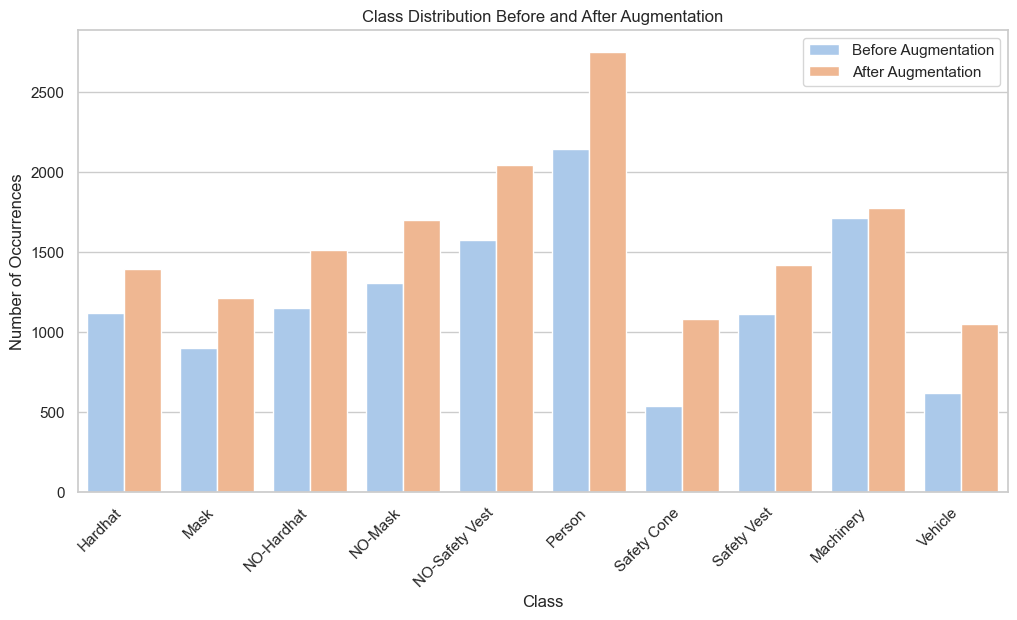

In [27]:
# ✅ Compute new class distribution from df_train_augmented
augmented_class_counts = {cls: 0 for cls in Config.PPE_CLASSES.keys()}
for _, row in df_train_augmented.iterrows():
    for cls in Config.PPE_CLASSES.keys():
        if row[cls] == 1:
            augmented_class_counts[cls] += 1

# Convert to numpy arrays
augmented_counts = np.array(list(augmented_class_counts.values()), dtype=np.float64)

# ✅ Compute standard deviation and coefficient of variation BEFORE augmentation
original_mean, original_std = np.mean(original_counts), np.std(original_counts)
original_cv = (original_std / original_mean) * 100

# ✅ Compute standard deviation and coefficient of variation AFTER augmentation
augmented_mean, augmented_std = np.mean(augmented_counts), np.std(augmented_counts)
augmented_cv = (augmented_std / augmented_mean) * 100

# ✅ Jensen-Shannon Divergence (Lower is better)
jsd = jensenshannon(original_counts, augmented_counts)

# ✅ Compute percentage change per class
relative_change = ((augmented_counts - original_counts) / original_counts) * 100

# ✅ Print results
print(f"📊 Standard Deviation of Class Distribution:")
print(f"   Before: {original_std:.2f}, After: {augmented_std:.2f}")

print(f"\n📊 Coefficient of Variation (Lower is better):")
print(f"   Before: {original_cv:.2f}%, After: {augmented_cv:.2f}%")

print(f"\n📊 Jensen-Shannon Divergence (Lower is better): {jsd:.4f}")

print("\n📊 Relative Change per Class (%):")
for cls, change in zip(Config.PPE_CLASSES.values(), relative_change):
    print(f"   {cls}: {change:.2f}%")

# ✅ Plot class distribution BEFORE and AFTER augmentation
df_plot = pd.DataFrame({
    "Class": np.array(list(Config.PPE_CLASSES.values())),  
    "Before Augmentation": original_counts,
    "After Augmentation": augmented_counts
})

# Melt for Seaborn
df_plot_melted = df_plot.melt(id_vars=["Class"], var_name="Dataset", value_name="Occurrences")

# ✅ Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x="Class", y="Occurrences", hue="Dataset", data=df_plot_melted, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Number of Occurrences")
plt.title("Class Distribution Before and After Augmentation")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()

In [28]:
# Paths to check
img_path = os.path.join(Config.WORKING_PATH, "train", "images")
label_path = os.path.join(Config.WORKING_PATH, "train", "labels")

# Count files
num_images = len([f for f in os.listdir(img_path) if f.endswith(".jpg")])
num_labels = len([f for f in os.listdir(label_path) if f.endswith(".txt")])

print(f"📂 Total images in train folder: {num_images}")
print(f"📂 Total labels in train folder: {num_labels}")

📂 Total images in train folder: 2949
📂 Total labels in train folder: 2949


In [29]:
# Load the YOLO11 model (pretrained weights)
model = YOLO(Config.BASE_MODEL) 

In [30]:
### Save YAML file
def save_yaml_file(dataset_yaml, dataset_config):
    with open(dataset_yaml, "w") as f:
        yaml.dump(dataset_config, f, default_flow_style=False)
    
    print(f"✅ Dataset YAML file saved at: {dataset_yaml}")

### read yaml file created
def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

In [31]:
# Define paths
dataset_yaml = os.path.join(Config.WORKING_PATH, "dataset.yaml")

# Create YAML content
dataset_config = {
    "path": Config.WORKING_PATH,  # Base path
    "train": "train/images",  # Train images folder
    "val": "valid/images",  # Validation images folder
    "test": "test/images",  # Test images folder
    "nc": len(Config.PPE_CLASSES),  # Number of classes
    "names": list(Config.PPE_CLASSES.values()),  # Class names
}

In [32]:
save_yaml_file(dataset_yaml, dataset_config)

✅ Dataset YAML file saved at: final_dataset\dataset.yaml
